In [56]:
import os
import sys
sys.path.append(os.path.abspath('../scripts'))
fig_path      = '../figures/'
data_path     = '../data/'

In [57]:
import netCDF4 as nc
import numpy as np
import xarray as xr
import warnings
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd 
import seaborn as sns
import cmocean as cmo
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from proj_utils import *
from mapping_utils import *

## (1) Open SLA data

In [58]:
ds_sla  = xr.open_dataset(data_path + 'sla_adt_gs_monthly.nc') # This is a monthly time series from AVISO with SLA and ADT for 1992-2023

In [59]:
ds_sla # Look at dataset to make sure all is in order

<xarray.Dataset> Size: 14MB
Dimensions:    (time: 365, latitude: 48, longitude: 100)
Coordinates:
  * latitude   (latitude) float32 192B 33.12 33.38 33.62 ... 44.38 44.62 44.88
  * longitude  (longitude) float32 400B -79.88 -79.62 -79.38 ... -55.38 -55.12
  * time       (time) datetime64[ns] 3kB 1993-01-31 1993-02-28 ... 2023-05-31
Data variables:
    adt        (time, latitude, longitude) float32 7MB ...
    sla        (time, latitude, longitude) float32 7MB ...
Attributes:
    Conventions:       CF-1.11
    title:             DT merged all satellites Global Ocean Gridded SSALTO/D...
    institution:       CLS, CNES
    source:            Altimetry measurements
    history:           2021-07-26 19:51:56Z: Creation
    contact:           servicedesk.cmems@mercator-ocean.eu
    references:        http://marine.copernicus.eu
    comment:           Sea Surface Height measured by Altimetry and derived v...
    subset:source:     ARCO data downloaded from the Marine Data Store using ...
    subset:productId:  SEALEVEL_GLO_PHY_L4_MY_008_047
    subset:datasetId:  cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1...
    subset:date:       2024-09-19T17:27:15.834Z

## (2) Do some processing of the SLA fields

In [60]:
ds_sla['longitude'] = ds_sla['longitude'] + 360 # Convert to degrees east
ds_sla['adt']       = ds_sla.adt.mean(dim = 'time')   # Take time mean average of adt 

ds_sla['adt']       = ds_sla['adt']*100 # Convert to cm
ds_sla['sla']       = ds_sla['sla']*100 # Convert to cm

ds_sla['sla_std']   = ds_sla.sla.std(dim = 'time') # Take std of sla 

ds_sla              = ds_sla.sel(time = slice('1993-01','2022-12'))

/Users/lillienders/gs-var-env/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [61]:
ds_sla = seasonal_detrend(ds_sla) # Remove seasonal cycle 
ds_sla = linear_detrend(ds_sla)   # Detrend linearly

time_fmt       = np.arange(np.datetime64('1993-01'), np.datetime64('2023-01'), dtype="datetime64[M]") 
ds_sla['time'] = time_fmt # Format time coordinate, which got messed up during linear detrending (should fix this w/in routine) 

In [62]:
ds_sla # Look at dataset again because why not have some awareness of what's going on

<xarray.Dataset> Size: 14MB
Dimensions:    (latitude: 48, longitude: 100, time: 360)
Coordinates:
  * latitude   (latitude) float32 192B 33.12 33.38 33.62 ... 44.38 44.62 44.88
  * longitude  (longitude) float32 400B 280.1 280.4 280.6 ... 304.4 304.6 304.9
  * time       (time) datetime64[s] 3kB 1993-01-01 1993-02-01 ... 2022-12-01
Data variables:
    adt        (latitude, longitude) float32 19kB nan nan ... -12.45 -13.14
    sla        (time, latitude, longitude) float64 14MB nan nan ... 1.001 0.6454
    sla_std    (latitude, longitude) float32 19kB nan nan 9.314 ... 5.272 5.364
Attributes:
    Conventions:       CF-1.11
    title:             DT merged all satellites Global Ocean Gridded SSALTO/D...
    institution:       CLS, CNES
    source:            Altimetry measurements
    history:           2021-07-26 19:51:56Z: Creation
    contact:           servicedesk.cmems@mercator-ocean.eu
    references:        http://marine.copernicus.eu
    comment:           Sea Surface Height measured by Altimetry and derived v...
    subset:source:     ARCO data downloaded from the Marine Data Store using ...
    subset:productId:  SEALEVEL_GLO_PHY_L4_MY_008_047
    subset:datasetId:  cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1...
    subset:date:       2024-09-19T17:27:15.834Z

## (3) Calc GSI & save to disk! 

The GSI calculation is done with the get_gsi.py routine (contained within proj_utils.py).

In [176]:
# Get GSI and save to netcdf format
gsi_array = get_gsi(ds_sla)
gsi_array.to_netcdf(data_path + 'gsi_altimetry_timeseries.nc')

In [177]:
# Get GSI lat/lons just in case, save to csv format
gsi_lon, gsi_lat = get_gsi_lat_lon(ds_sla.adt, ds_sla.sla_std)
gsi_locs_df = pd.DataFrame({'longitude': gsi_lon, 'latitude': gsi_lat})
gsi_locs_df.to_csv(data_path + 'gsi_altimetry_locations.csv')

## (4) Compute normalized and filtered GSI just for plotting purposes

In [187]:
gsi_norm = (gsi_array - np.nanmean(gsi_array))/np.nanstd(gsi_array)
gsi_f    = lanczos_bandpass(gsi_norm, low_freq = 12*6, high_freq = 12*11, window = 12) 
gsi_f    = (gsi_f - gsi_f.mean(dim='time'))/gsi_f.std(dim = 'time')

## (5) Do some plotting to check things out

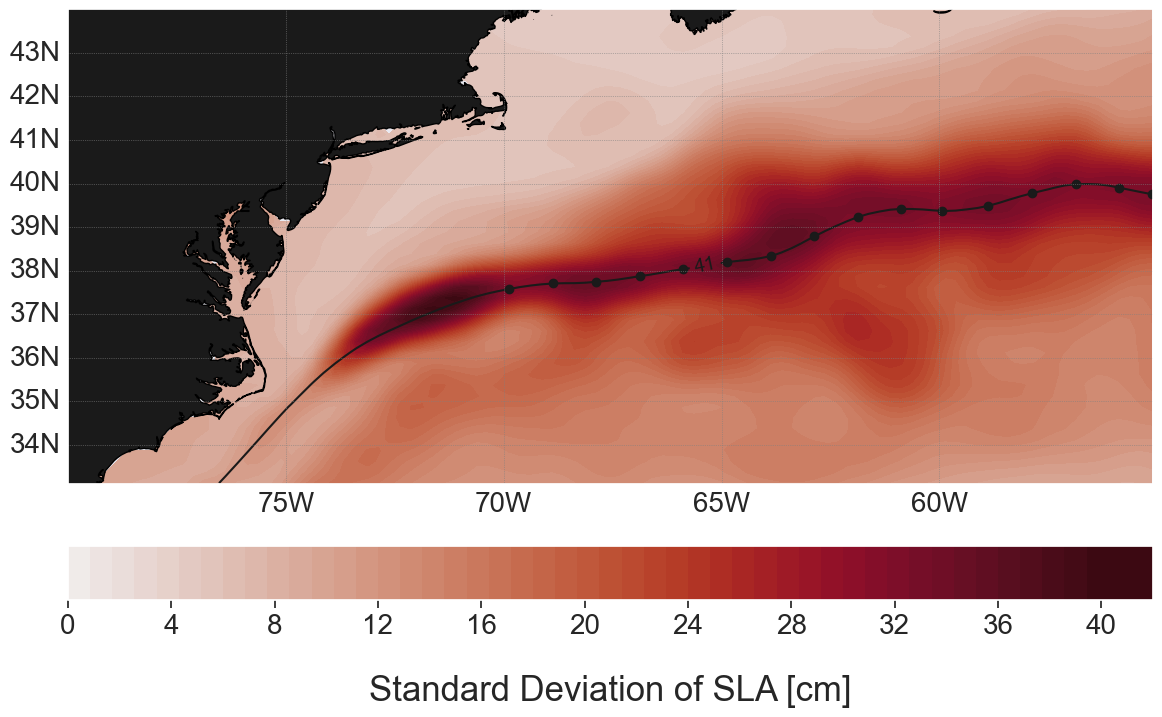

In [184]:
bbox = [280, 304.9, 33.1, 44]
fig = plt.figure(figsize=(14, 8))
crs = ccrs.PlateCarree()
ax = plt.subplot(1, 1, 1, projection=crs)
ax.set_extent(bbox, crs)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, facecolor='k', zorder=1)

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle=':')
gl.top_labels = gl.right_labels = False
gl.ylocator = mticker.FixedLocator(np.arange(34,44))
gl.xformatter = LongitudeFormatter(degree_symbol='')
gl.yformatter = LatitudeFormatter(degree_symbol='')

levels = np.linspace(0,42,50)
colorplot = plt.contourf(ds_sla.longitude,ds_sla.latitude,ds_sla.sla_std, levels=levels, cmap='cmo.amp', zorder=0)
cs = plt.contour(ds_sla.longitude,ds_sla.latitude,ds_sla.adt, levels=[get_max_contour(ds_sla.adt, ds_sla.sla_std)], colors='k', zorder=0)
ax.clabel(cs, inline=True, fontsize=14)  # fmt sets the label format

max_data = int(round(np.nanmax(abs(ds_sla.sla_std)), -1))
colorplot.set_clim(0, max_data)

plt.scatter(gsi_lon, gsi_lat, color='k')

plt.xlabel('Latitude ', fontsize=25)
plt.ylabel('Longitude', fontsize=25)
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}

cbar = plt.colorbar(colorplot, fraction=0.1, pad=0.1, orientation='horizontal',
                    ticks=np.linspace(0, max_data, 11))
cbar.set_label('Standard Deviation of SLA [cm]', size='25', labelpad=25)
cbar.ax.tick_params(labelsize=20)
#plt.savefig(fig_path + 'gsi_std_altimetry.png', format='png', bbox_inches="tight",dpi=500)

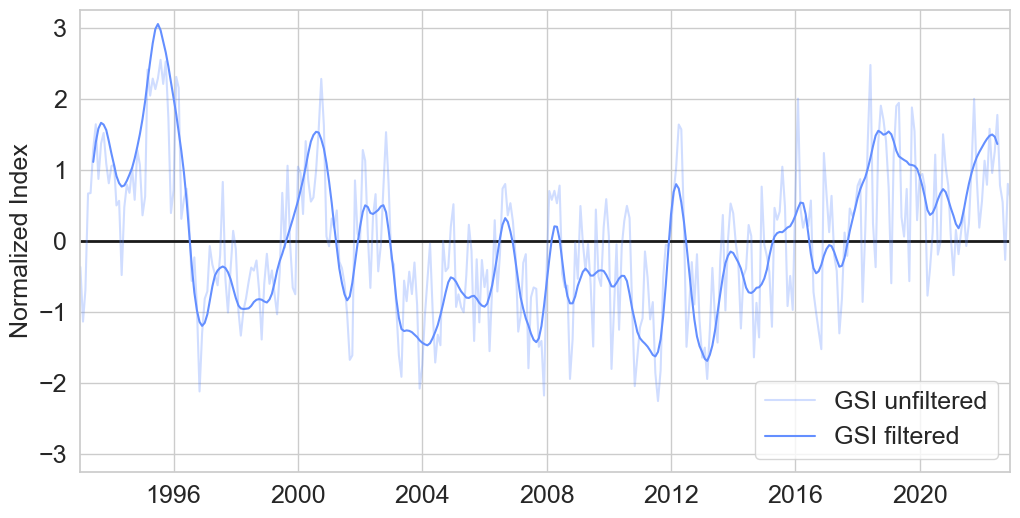

In [202]:
style = sns.set_style("whitegrid")
gsi_c = '#648fff'

fig   = plt.figure(figsize=(12, 6))
zline = plt.axhline(0, color='k', linewidth=2)

uf    = plt.plot(gsi_norm.time, gsi_norm, color = gsi_c, alpha = 0.3, label = 'GSI unfiltered')
f     = plt.plot(gsi_f.time, gsi_f, color = gsi_c, zorder = 10, label = 'GSI filtered')

xtix  = plt.yticks(fontsize=18)
ytix  = plt.xticks(fontsize=18)

ylab  = plt.ylabel('Normalized Index', fontsize = 18)
xlab  = plt.xlabel('',fontsize = 18)

xlim  = plt.xlim(gsi_norm.time[0],gsi_norm.time[-1])
ylim  = plt.ylim(-3.25,3.25)

leg   = plt.legend(fontsize = 18)

#plt.savefig(fig_path + 'gsi_time_series_altimetry.png', format='png', bbox_inches="tight",dpi=500)